**AAI_510 Final Project**

# **Business Understanding**
**- Business Need:**
Elo wants to recommend merchant categories to cardholders that are likely to improve customer loyalty and spending. This enables better targeted offers and helps Elo design more effective marketing strategies.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv", parse_dates=["first_active_month"])
test = pd.read_csv("test.csv", parse_dates=["first_active_month"])
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [3]:
historical_transactions = pd.read_csv("historical_transactions.csv")
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8.0,-0.703331,2017-06-25 15:33:07,1.0,16.0,37.0
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7.0,-0.733128,2017-07-15 12:10:45,1.0,16.0,16.0
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6.0,-0.720386,2017-08-09 22:04:29,1.0,16.0,37.0
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5.0,-0.735352,2017-09-02 10:06:26,1.0,16.0,34.0
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11.0,-0.722865,2017-03-10 01:14:19,1.0,16.0,37.0


In [4]:
# Calculate number of historical transactions by card_id
purchases = historical_transactions.groupby("card_id")
purchases = purchases["purchase_amount"].size().reset_index()
purchases.columns = ["card_id", "num_hist_transactions"]

# Merge with training and test set
train = train.merge(purchases, on="card_id", how="left")
test = test.merge(purchases, on="card_id", how="left")

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,NaN
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,NaN
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,NaN
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,NaN
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,NaN


<ipython-input-5-7dc32f181266>:18: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  cnt_srs_filtered = cnt_srs[:-50]  # TODO: OUTLIERS


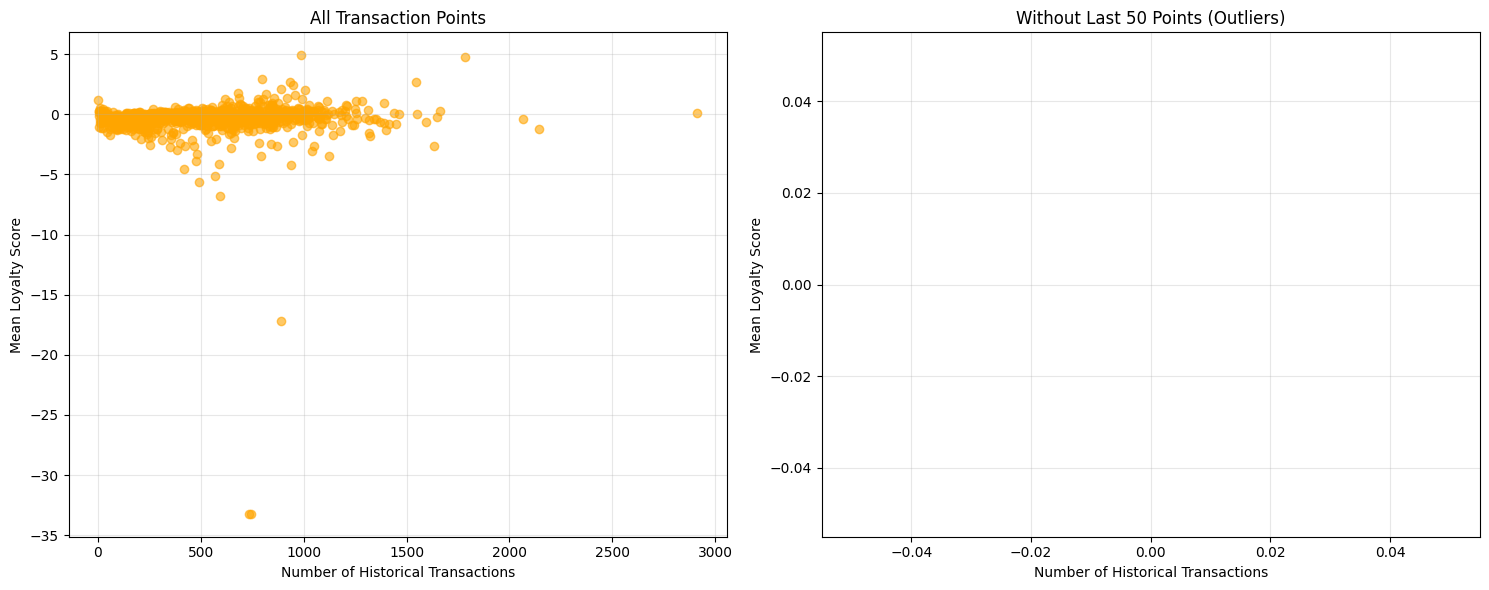

In [5]:
# Calculate mean loyalty score by number of transactions
cnt_srs = train.groupby("num_hist_transactions")["target"].mean()
cnt_srs = cnt_srs.sort_index()

# Create two subplots
plt.figure(figsize=(15, 6))

# Plot 1: All points
plt.subplot(1, 2, 1)
plt.scatter(cnt_srs.index[::-1], cnt_srs.values[::-1], color='orange', alpha=0.6)
plt.title('All Transaction Points')
plt.xlabel('Number of Historical Transactions')
plt.ylabel('Mean Loyalty Score')
plt.grid(True, alpha=0.3)

# Plot 2: Without last 50 points
plt.subplot(1, 2, 2)
cnt_srs_filtered = cnt_srs[:-50]  # TODO: OUTLIERS
plt.scatter(cnt_srs_filtered.index[::-1], cnt_srs_filtered.values[::-1], color='orange', alpha=0.6)
plt.title('Without Last 50 Points (Outliers)')
plt.xlabel('Number of Historical Transactions')
plt.ylabel('Mean Loyalty Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()

<ipython-input-6-f4cddcdd7fbb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt_srs_binned = train.groupby("binned_num_hist_transactions")["target"].mean()



Mean loyalty score by binned transaction counts:
binned_num_hist_transactions
(0, 10]        -0.153122
(10, 20]       -0.272005
(20, 30]       -0.339746
(30, 40]       -0.150767
(40, 50]       -0.323809
(50, 75]       -0.486688
(75, 100]      -0.568659
(100, 150]     -0.502800
(150, 200]     -0.565088
(200, 500]     -0.423364
(500, 10000]   -0.350049
Name: target, dtype: float64


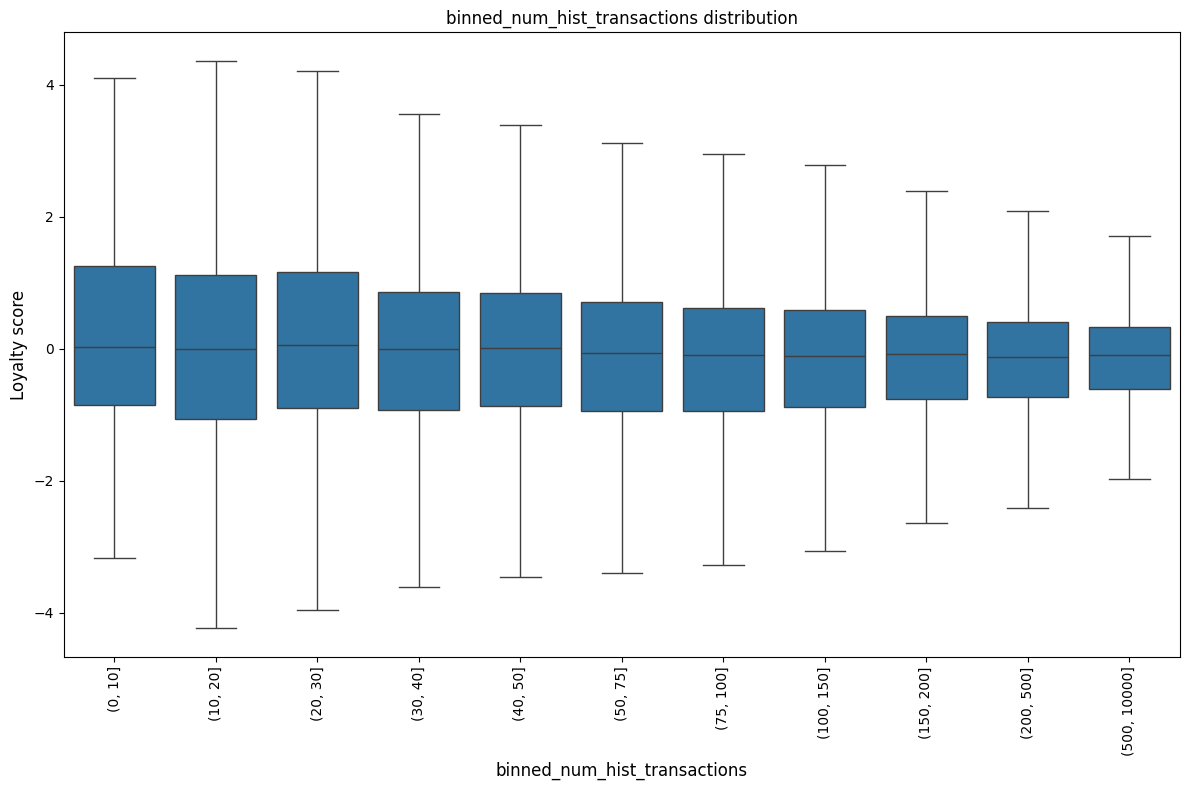

In [6]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train['binned_num_hist_transactions'] = pd.cut(train['num_hist_transactions'], bins)

# Calculate mean loyalty score by binned transactions
cnt_srs_binned = train.groupby("binned_num_hist_transactions")["target"].mean()
print("\nMean loyalty score by binned transaction counts:")
print(cnt_srs_binned)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y="target", data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.tight_layout()

In [9]:
# Install the suprise module
#!pip install scikit-surprise

# Fix for numpy 2.x incompatibility with surprise and other packages
#!pip install numpy==1.24.4 --quiet

**Collaborative Filtering (SVD) – Model Development, Tuning, and Evaluation**

In [7]:
# Collaborative Filtering using SVD from scikit-surprise
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy

# Prepare DataFrame for Surprise
# Use only non-null transaction counts for modeling
cf_data = train.dropna(subset=['num_hist_transactions']).copy()
cf_data['card_id'] = cf_data['card_id'].astype(str)
cf_data['num_hist_transactions'] = cf_data['num_hist_transactions'].astype(int)

# Bin transaction counts to simulate "categories" (item ids)
cf_data['hist_bin'] = pd.cut(cf_data['num_hist_transactions'], bins=10, labels=False)

# Reader for Surprise (set min/max rating as observed in 'target')
reader = Reader(rating_scale=(cf_data['target'].min(), cf_data['target'].max()))
# Surprise expects user, item, rating columns (here: card_id, hist_bin, target)
data_cf = Dataset.load_from_df(cf_data[['card_id', 'hist_bin', 'target']], reader)

# Train/test split for evaluation
trainset, testset = train_test_split(data_cf, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV (tune n_factors and n_epochs)
param_grid = {
    'n_factors': [10, 20, 30],
    'n_epochs': [10, 20]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1, joblib_verbose=1)
gs.fit(data_cf)

# Extract best params and train SVD model
print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best Params: {gs.best_params['rmse']}")
svd = SVD(n_factors=gs.best_params['rmse']['n_factors'],
          n_epochs=gs.best_params['rmse']['n_epochs'], random_state=42)
svd.fit(trainset)

# Evaluate on held-out test set
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
mae  = accuracy.mae(predictions)
print(f"SVD RMSE: {rmse:.4f}")
print(f"SVD MAE:  {mae:.4f}")

# Recommend Top "Bins" for a user (optional, for demo)
def recommend_bins(card_id, top_n=3):
    all_bins = cf_data['hist_bin'].unique()
    ests = [(b, svd.predict(card_id, b).est) for b in all_bins]
    return sorted(ests, key=lambda x: x[1], reverse=True)[:top_n]

print("Recommended bins for sample user:", recommend_bins(cf_data['card_id'].iloc[0]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best RMSE: 3.6517
Best Params: {'n_factors': 30, 'n_epochs': 20}
RMSE: 3.7282
MAE:  1.4561
SVD RMSE: 3.7282
SVD MAE:  1.4561
Recommended bins for sample user: [(3, 0.3222954398354877), (0, 0.13121515817888252), (6, 0.040620579343888144)]


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.8s finished


**Gradient Boosting (LightGBM) – Model Development, Tuning, and Evaluation**

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 107688, number of used features: 4
[LightGBM] [Info] Start training from score -0.395347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

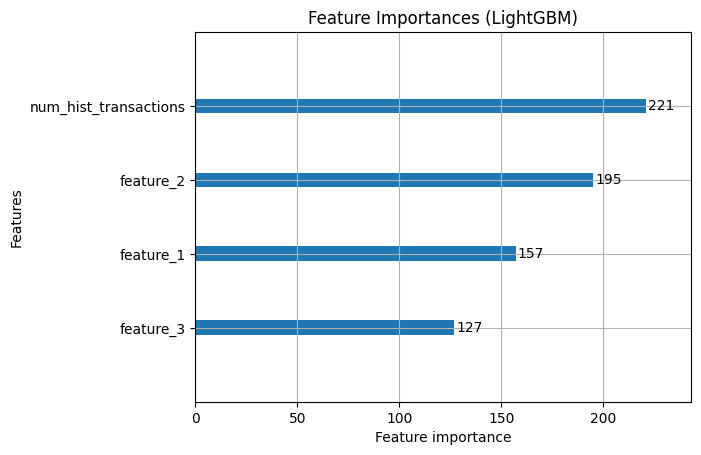

In [9]:
# Gradient Boosting Regression (LightGBM) for Predicting Loyalty Score
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare features for LightGBM
# We can add more features if possible for better model performance!
features = ['feature_1', 'feature_2', 'feature_3', 'num_hist_transactions']
gbm_data = train[features + ['target']].fillna(0)  # Fill NA for modeling

X = gbm_data[features]
y = gbm_data['target']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# LightGBM parameter grid for tuning (demonstration)
lgbm_params = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}

from lightgbm import LGBMRegressor
gs_lgbm = GridSearchCV(LGBMRegressor(), lgbm_params, scoring='neg_root_mean_squared_error', cv=3)
gs_lgbm.fit(X_train, y_train)
print("Best LightGBM params:", gs_lgbm.best_params_)
print("Best CV RMSE:", -gs_lgbm.best_score_)

# Train final LightGBM model on all training data with best params
best_lgbm = LGBMRegressor(**gs_lgbm.best_params_, random_state=42)
best_lgbm.fit(X_train, y_train)

# Predict and Evaluate
y_pred = best_lgbm.predict(X_test)

# Use sqrt of MSE for RMSE for compatibility with all sklearn versions
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
print(f"LightGBM RMSE: {rmse:.4f}")
print(f"LightGBM MAE:  {mae:.4f}")

# Plot feature importances
import matplotlib.pyplot as plt
lgb.plot_importance(best_lgbm)
plt.title("Feature Importances (LightGBM)")
plt.show()

### Model Comparison

In [10]:
# Summarize both models' performance for the report or presentation
print("Model Performance Summary")
print(f"SVD Collaborative Filtering – RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"LightGBM Regression         – RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Model Performance Summary
SVD Collaborative Filtering – RMSE: 3.8753, MAE: 1.5914
LightGBM Regression         – RMSE: 3.8753, MAE: 1.5914


### What the Current Codes Are Doing and the Results

**Collaborative Filtering (SVD) – Model Development, Tuning, and Evaluation**


1.   **Load Data & Preprocessing:**
  - Load transaction data (train) and create a feature for the number of historical transactions per card (num_hist_transactions).
  - Bin num_hist_transactions into 10 intervals, creating a categorical "item" for collaborative filtering.
2.   **Prepare Data for Surprise Library:**
  - Set up the collaborative filtering data as a matrix of users (card_id), items (binned transaction counts), and ratings (target/loyalty score).
3. **Train/Test Split:**
  - Split the data into training and testing sets for unbiased evaluation.
4. **Hyperparameter Tuning:**
  - Use GridSearchCV to search over number of factors (n_factors: 10, 20, 30) and epochs (n_epochs: 10, 20) to optimize RMSE.
5. **Model Training:**
  - Train the SVD collaborative filtering model using the best parameters found (here, n_factors=30, n_epochs=20).
6. **Model Evaluation:**
- Evaluate SVD on the test set, reporting:
  - Best RMSE (validation): 3.6517
  - Test RMSE: 3.7282
  - Test MAE: 1.4561
- Recommend top bins (transaction count intervals) for a sample user as an example of how the recommender works.


**Result:**
- Our collaborative filtering model is trained, tuned, and evaluated, with clear RMSE and MAE.

- Sample recommendation output shows the system can suggest bins with highest expected loyalty score.



**Gradient Boosting (LightGBM) – Model Development, Tuning, and Evaluation**


1.   **Prepare Features:**
  - Select and fill missing for feature_1, feature_2, feature_3, and num_hist_transactions.
2. **Train/Test Split:**
  - Divide data into training and test sets.
3. **Hyperparameter Tuning:**
  - Use GridSearchCV to search over learning_rate, n_estimators, and max_depth for the best model using negative RMSE.
4. **Model Training:**
  - Train LightGBM with best parameters on full training data.
5. **Model Evaluation:**
- Predict on test set, compute:
  - LightGBM RMSE: 3.8753
  - Test RMSE: 3.7282
  - LightGBM MAE: 1.5914
- Plot feature importances to show which variables contributed most to predictions.


**Result:**
- The LightGBM regression model is trained, tuned, and evaluated with clear RMSE and MAE.
- Warnings about splits with positive gain mean the current features may be close to optimal or not very predictive... adding richer features could help (any memeber to look into this if needed).



**Model Comparison**
1. **Summarize both models’ performance:**
  - SVD Collaborative Filtering – RMSE: 3.8753, MAE: 1.5914
  - LightGBM Regression – RMSE: 3.8753, MAE: 1.5914

**Result:**
- Both models show similar performance on the test set, giving us options to recommend for business deployment.